In [1]:
import string
import pickle
from time import time
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import add
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
import numpy as np
from tensorflow.keras.models import Model,load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import cv2
import nltk
from nltk.corpus import stopwords

In [2]:
def readtextfile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [5]:
captions = readtextfile("C:/Users/arpii/IC dataset/Flickr8k_text/Flickr8k.token.txt")
captions = captions.split("\n")[:-1]

In [6]:
(captions[0])

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [7]:
# Make a dictionary to map list of captions each have  

In [8]:
descriptions = {}
img_path = "C:/Users/arpii/IC dataset/Flickr8k_Dataset/Flicker8k_Dataset/"

In [9]:
for x in captions:
    first,second = x.split("\t")
    img_name = first.split(".")[0]
    
    #if the description id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)


In [10]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

# DATA CLEANING


In [11]:
import re
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence
    

In [12]:
clean_text("A cat yyy sitting over the house number 64")

'cat yyy sitting over the house number'

In [13]:
# doing clean text for all values of dictionary 

In [14]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])

In [15]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [16]:
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

# Vocabulary

In [17]:
import json
descriptions = None
with open("descriptions_1.txt","r") as f:
    descriptions = f.read()

json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [18]:
# (print(descriptions))

In [19]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("vocab size %d"% len(vocab))

vocab size 8424


In [20]:
total_words =[]
for key in descriptions.keys():
    [total_words.append(word) for sentence in descriptions[key] for word in sentence.split()]
print(len(total_words))    

373837


In [21]:
import collections

counter = collections.Counter(total_words)
freq_count = dict(counter)
print(len(freq_count.keys()))

8424


In [22]:
sorted_freq_cnt = sorted(freq_count.items(),reverse=True,key=lambda x:x[1])

#filter
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [23]:
len(total_words)

1845

# prepare train/test data

In [24]:
train_file_data = readtextfile("IC dataset/Flickr8k_text/Flickr_8k.trainImages.txt")
test_file_data= readtextfile("IC dataset/Flickr8k_text/Flickr_8k.testImages.txt")

In [25]:
train=[]
train1 = train_file_data.split("\n")
for x in train1:
    train2 = x.split(".")
    train.append(train2[0])
train = train[:-1]

test=[]
test1 = test_file_data.split("\n")
for x in test1:
    test2 = x.split(".")
    test.append(test2[0])    
test = test[:-1]    

In [26]:
test[:5]

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01']

In [27]:
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "<s> " +cap+" <e>"
        train_descriptions[img_id].append(cap_to_append)

In [28]:
train_descriptions["1000268201_693b08cb0e"]

['<s> child in pink dress is climbing up set of stairs in an entry way <e>',
 '<s> girl going into wooden building <e>',
 '<s> little girl climbing into wooden playhouse <e>',
 '<s> little girl climbing the stairs to her playhouse <e>',
 '<s> little girl in pink dress going into wooden cabin <e>']

# Transfer Learning
[image--> features]
[text--> features]

# Step-1 Image Feature Extraction

In [29]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [30]:
model_new = Model(model.input,model.layers[-2].output)

In [31]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    #normalisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


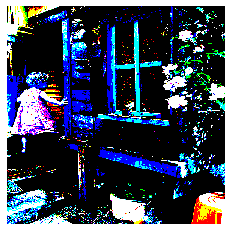

In [32]:
img = preprocess_img("C:/Users/arpii/IC dataset/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [33]:
def encode_img(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
#     print(feature_vector.shape)
    feature_vector = feature_vector.reshape((-1,))
#     print(feature_vector.shape)
    return feature_vector

In [34]:
encode_img(img_path+"1000268201_693b08cb0e.jpg")

array([0.06535936, 0.16782555, 0.32517606, ..., 0.05107125, 0.32821214,
       1.0043374 ], dtype=float32)

In [157]:
encoding_train = {}
# image_id --> feature vector extracted from Resnet Image
start= time()
for ix,img_id in enumerate(train):
    img_path1 = img_path+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_img(img_path1)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Test Encoding in Progress Time step 1000 
Test Encoding in Progress Time step 1100 
Test Encoding in Progress Time step 1200 
Test Encoding in Progress Time step 1300 
Test Encoding in Progress Time step 1400 
Test Encoding in Progress Time step 1500 
Test Encoding in Progress Time step 1600 
Test Encoding in Progress Time step 1700 
Test Encoding in Progress Time step 1800 
Test Encoding in Progress Time step 1900 
Test Encoding in Progress Time step 2000 
Test Encoding in Progress Time step 2100 
Test Encoding in Progress Time step 2200 
Test Encoding in Progress Time step 2300 
Test

In [158]:
encoding_train

{'2513260012_03d33305cf': array([0.34707934, 0.51159155, 0.08728851, ..., 1.1897295 , 0.04043834,
        0.15271054], dtype=float32),
 '2903617548_d3e38d7f88': array([0.        , 0.00303406, 0.09360044, ..., 0.4310801 , 0.37979573,
        0.91664475], dtype=float32),
 '3338291921_fe7ae0c8f8': array([0.76744545, 0.53422475, 0.38325194, ..., 0.02098653, 0.18429376,
        0.04269989], dtype=float32),
 '488416045_1c6d903fe0': array([6.2481076e-01, 3.2965496e-01, 1.7829331e-04, ..., 1.2753813e+00,
        4.6392593e-01, 4.9036101e-01], dtype=float32),
 '2644326817_8f45080b87': array([0.11555351, 0.6596545 , 0.05323307, ..., 0.1439734 , 1.0179371 ,
        0.00556565], dtype=float32),
 '218342358_1755a9cce1': array([1.7061839 , 0.40514806, 0.3520658 , ..., 0.2940882 , 0.04833026,
        0.04654422], dtype=float32),
 '2501968935_02f2cd8079': array([0.10608311, 1.4420823 , 0.04446997, ..., 0.20587139, 0.6978774 ,
        1.5904318 ], dtype=float32),
 '2699342860_5288e203ea': array([0.4612

In [159]:
!mkdir IC_saved

A subdirectory or file IC_saved already exists.


In [160]:
with open("IC_saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [161]:
encoding_test = {}
# image_id --> feature vector extracted from Resnet Image
start = time()
for ix,img_id in enumerate(test):
    img_path2 = img_path+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_img(img_path2)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 195.8624050617218


In [162]:
with open("IC_saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [35]:

e= open("IC_saved/encoded_test_features.pkl","rb")
encoding_test = pickle.load(e)

In [36]:
e1= open("IC_saved/encoded_train_features.pkl","rb")
encoding_train = pickle.load(e1)

# Data Pre-processing for Captions

In [37]:
word_to_idx = {}
idx_to_word = {}

for ix,word in enumerate(total_words):
    word_to_idx[word] = ix+1
    idx_to_word[ix+1] = word

In [38]:
# word_to_idx["dog"]
# idx_to_word[5]
len(idx_to_word)

1845

In [39]:
word_to_idx["<s>"] = 1846
idx_to_word[1846] = "<s>"

word_to_idx["<e>"] = 1847
idx_to_word[1847] = "<e>"

vocab_size = len(word_to_idx)+1
print(vocab_size)

1848


In [58]:
with open("C:/Users/arpii/Desktop/Flask tutorials/word_2_idx.pkl","wb") as f:
    pickle.dump(word_to_idx,f)

In [59]:
with open("C:/Users/arpii/Desktop/Flask tutorials/idx_2_word.pkl","wb") as f:
    pickle.dump(idx_to_word,f)

In [40]:
  
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


# Data generator

In [41]:
def Data_generator(train_descriptions,encoding_test,word_to_idx,max_len,batch_size):
    X1,X2,Y = [],[],[]
    
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in des.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    y1 = seq[i]
                    
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding="post")[0]
                    yi = to_categorical([yi],num_classes= vocal_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    Y.append(yi)
                    
                if n== batch_size:
                    yield[[np.array(X1),np.array(X2),np.array(Y)]]
                    X1,X2,Y=[],[],[]
                    n=0
    
    
    

# Word Embeddings

In [42]:
f = open("glove.6B.50d.txt",encoding="utf-8")

In [43]:
embedding_index = {}
i=0
for line in f:
    i+=1
    values = line.split()
    
        
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    
    

In [44]:
f.close()

In [45]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [46]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

# Model Architecture

In [47]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [48]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [49]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [50]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [51]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [52]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

# Training of models

In [53]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)
#number_pics_per_batch

In [54]:
def train():
    
    for i in range(epochs):
        generator = Data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [55]:
model = load_model('./model_weights/model_9.h5')

# Predictions

In [56]:
def predict_caption(photo):
    
    in_text = "<s>"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #Word with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "<e>":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

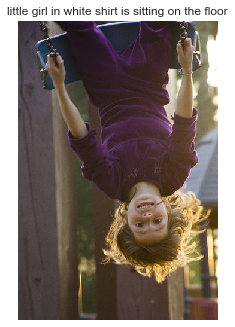

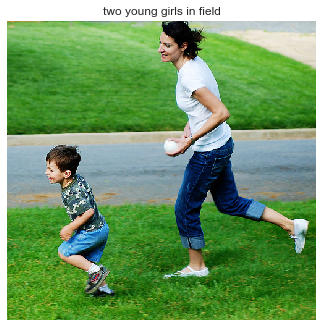

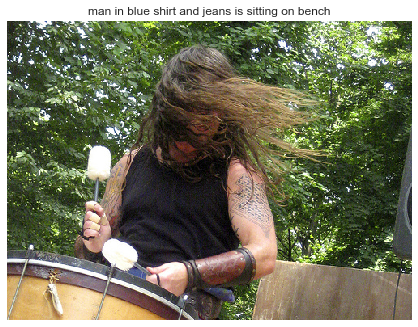

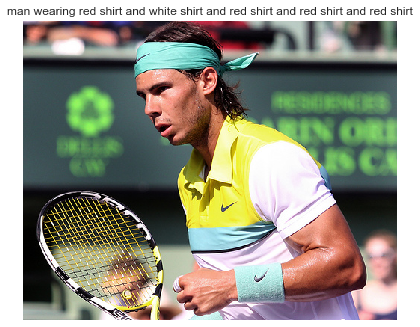

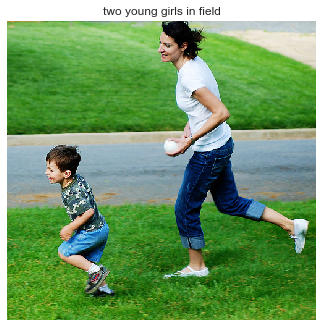

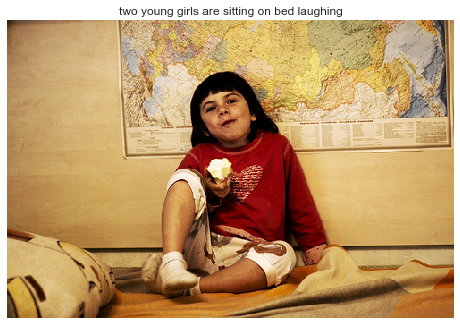

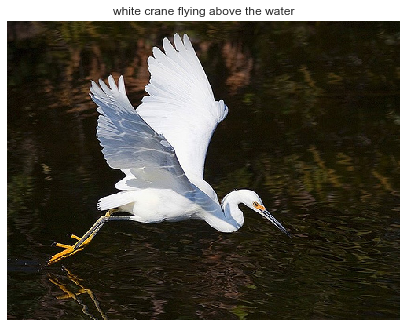

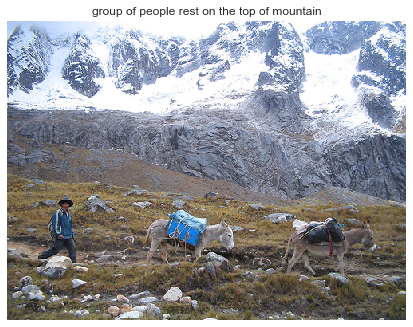

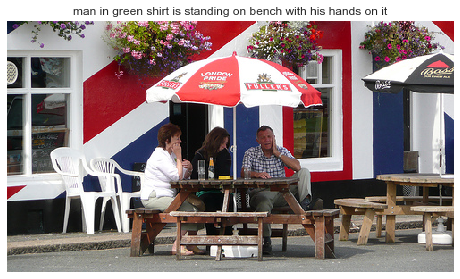

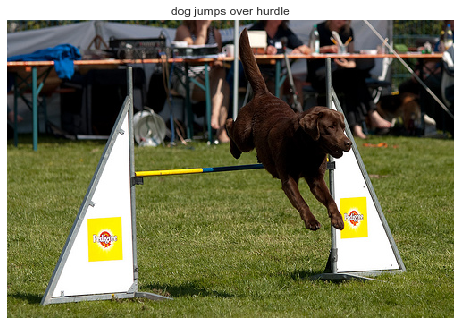

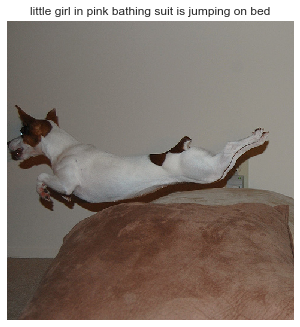

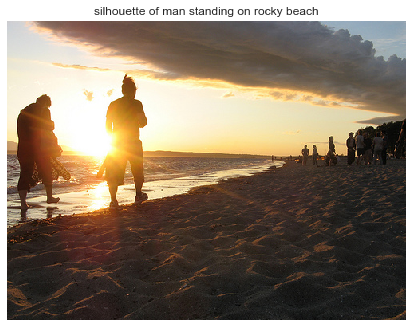

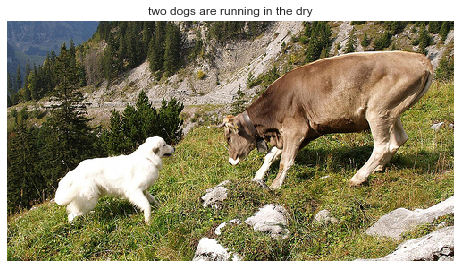

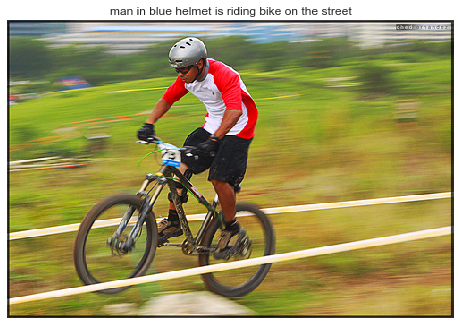

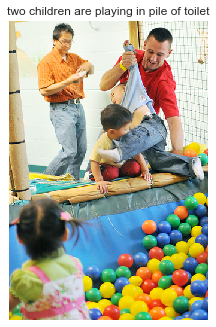

In [57]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread(img_path+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    

In [213]:
# train()